# Define the system  

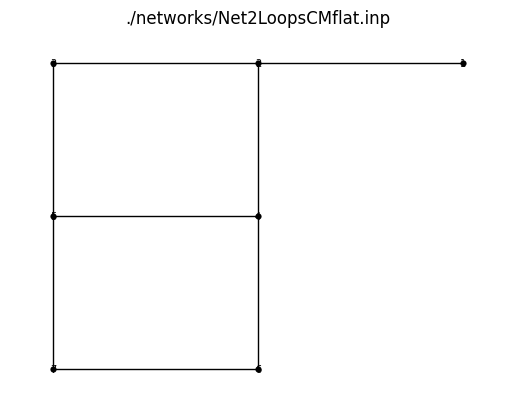

<Axes: title={'center': './networks/Net2LoopsCMflat.inp'}>

In [1]:
import wntr
import wntr_quantum
import numpy as np

# Create a water network model
# inp_file = './networks/Net0.inp'
inp_file = './networks/Net2LoopsCMflat.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)


## Run with the original Cholesky EPANET simulator

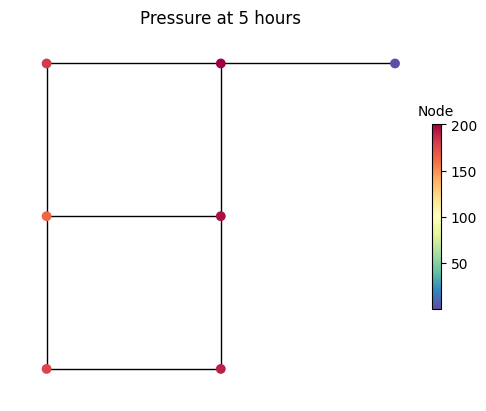

<Axes: title={'center': 'Pressure at 5 hours'}>

In [2]:
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()
# Plot results on the network
pressure_at_5hr = results.node['pressure'].loc[0, :]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_5hr, node_size=50,
                        title='Pressure at 5 hours', node_labels=False)

In [3]:
ref_pressure = results.node['pressure'].values[0]
ref_pressure

array([2.007e+02, 1.817e+02, 1.956e+02, 1.638e+02, 1.905e+02, 1.778e+02, 4.395e-07], dtype=float32)

In [4]:
ref_rate = results.link['flowrate'].values[0]
ref_rate

array([ 0.311,  0.051,  0.232,  0.031,  0.168,  0.076,  0.023, -0.021], dtype=float32)

In [5]:
ref_values = np.append(ref_rate, ref_pressure)
ref_values

array([ 3.111e-01,  5.111e-02,  2.322e-01,  3.108e-02,  1.678e-01,  7.613e-02,  2.334e-02, -2.058e-02,  2.007e+02,  1.817e+02,  1.956e+02,  1.638e+02,  1.905e+02,  1.778e+02,  4.395e-07], dtype=float32)

## Run with the QUBO Polynomial Solver

In [6]:
wn = wntr.network.WaterNetworkModel(inp_file)

In [7]:
from wntr_quantum.sim.solvers.qubo_polynomial_solver import QuboPolynomialSolver
from qubops.solution_vector import SolutionVector_V2 as SolutionVector
from qubops.encodings import  RangedEfficientEncoding, PositiveQbitEncoding

nqbit = 5
step = (15/(2**nqbit-1))
flow_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+0., var_base_name="x")

nqbit = 5
step = (1000/(2**nqbit-1))
head_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+0.0, var_base_name="x")

net = QuboPolynomialSolver(wn, flow_encoding=flow_encoding, 
              head_encoding=head_encoding)
net.verify_encoding()

Head Encoding : 0.000000 => 1000.000000 (res: 32.258065)
Flow Encoding : -15.000000 => -0.000000 | 0.000000 => 15.000000 (res: 0.483871)


Solve the system classically

In [8]:
from wntr_quantum.sim.qubo_hydraulics import create_hydraulic_model_for_qubo
model, model_updater = create_hydraulic_model_for_qubo(wn)
net.create_index_mapping(model)
net.matrices = net.initialize_matrices(model)

ref_sol, encoded_ref_sol, cvgd = net.classical_solutions()
ref_sol / ref_values[:-1]

/home/nico/QuantumApplicationLab/QuantumNewtonRaphson/quantum_newton_raphson/utils.py:74: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn("spsolve requires A be CSC or CSR matrix format", SparseEfficiencyWarning)


array([1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.999, 1.   , 1.001, 1.   , 1.001, 1.   , 1.001])

[]

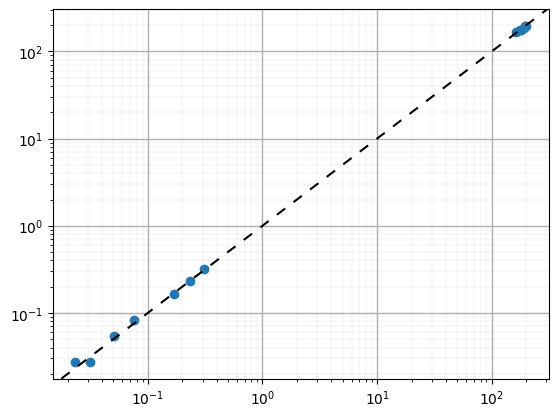

In [9]:
import matplotlib.pyplot as plt 
plt.scatter(ref_values[:-1], encoded_ref_sol)
plt.axline((0, 0.0), slope=1, color="black", linestyle=(0, (5, 5)))
plt.grid(which="major", lw=1)
plt.grid(which="minor", lw=0.1)
plt.loglog()

In [32]:
from wntr_quantum.sim.qubo_hydraulics import create_hydraulic_model_for_qubo
from dwave.samplers import SimulatedAnnealingSampler, TabuSampler, RandomSampler

sampler = SimulatedAnnealingSampler()
# sampler = TabuSampler()
# sampler = RandomSampler()
model, model_updater = create_hydraulic_model_for_qubo(wn)
net.solve(model, strength=1e8, num_sweeps=10000, num_reads=100, options={"sampler" : sampler})
sol = net.extract_data_from_model(model)

In [33]:
solutions,energies,statuses = net.analyze_sampleset()

Text(0, 0.5, 'QUBO Solution')

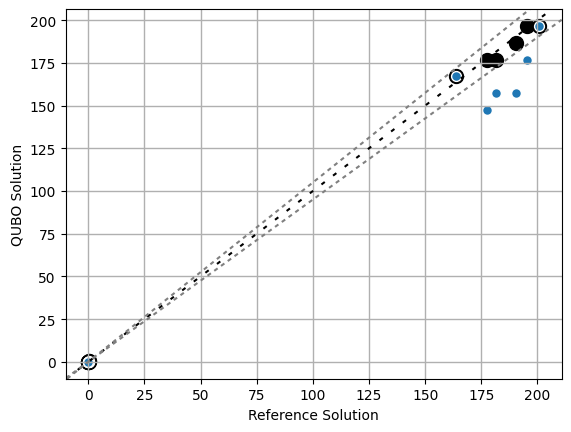

In [34]:
import matplotlib.pyplot as plt 
plt.scatter(ref_values[:-1], encoded_ref_sol, c='black', s=100, label='Best solution')
for s in solutions[:1]:
    plt.scatter(ref_values[:-1], s, s=50, lw=1, edgecolors='w', label='Sampled solution')
plt.axline((0, 0.0), slope=1, color="black", linestyle=(0, (2, 5)))
plt.axline((0, 0.0), slope=1.05, color="grey", linestyle=(0, (2, 2)))
plt.axline((0, 0.0), slope=0.95, color="grey", linestyle=(0, (2, 2)))
plt.grid(which="major", lw=1)
plt.grid(which="minor", lw=0.1)
plt.xlabel('Reference Solution')
plt.ylabel('QUBO Solution')
# plt.legend()
# plt.xlim([0.01,0.1])
# plt.ylim([0.01,0.1])
# plt.loglog()

In [35]:
net.qubo.verify_quadratic_constraints(net.sampleset)

[]

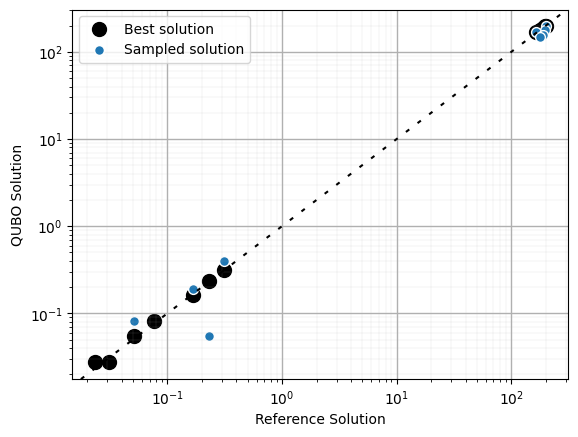

In [36]:
import matplotlib.pyplot as plt 
plt.scatter(ref_values[:-1], encoded_ref_sol, c='black', s=100, label='Best solution')
plt.scatter(ref_values[:-1], sol, s=50, lw=1, edgecolors='w', label='Sampled solution')
plt.axline((0, 0.0), slope=1, color="black", linestyle=(0, (2, 5)))
plt.axline((0, 0.0), slope=1.05, color="grey", linestyle=(0, (2, 2)))
plt.axline((0, 0.0), slope=0.95, color="grey", linestyle=(0, (2, 2)))
plt.grid(which="major", lw=1)
plt.grid(which="minor", lw=0.1)
plt.xlabel('Reference Solution')
plt.ylabel('QUBO Solution')
plt.legend()
# plt.xlim([0.01,0.1])
# plt.ylim([0.01,0.1])
plt.loglog()

In [37]:
net.diagnostic_solution(sol, ref_sol)

Head Encoding : 0.000000 => 1000.000000 (res: 32.258065)
Flow Encoding : -15.000000 => -0.000000 | 0.000000 => 15.000000 (res: 0.483871)


Error (%): [  0.      0.      0.    100.      0.    100.    200.    200.    -27.728 -60.821  76.397 100.    -14.324 100.     41.318 -33.224   2.05   13.496   9.519  -1.882  17.447  17.085]


sol :  [ 1.000e+00  1.000e+00  1.000e+00  0.000e+00  1.000e+00  0.000e+00 -1.000e+00  1.000e+00  1.403e+01  2.903e+00  1.935e+00  0.000e+00  6.774e+00  0.000e+00  4.839e-01  9.677e-01  6.452e+02  5.161e+02  5.806e+02  5.484e+02  5.161e+02  4.839e+02]
ref :  [  1.      1.      1.      1.      1.      1.      1.     -1.     10.986   1.805   8.2     1.098   5.925   2.688   0.825   0.726 658.662 596.652 641.733 538.256 625.212 583.576]
diff:  [  0.      0.      0.      1.      0.      1.      2.     -2.     -3.046  -1.098   6.265   1.098  -0.849   2.688   0.341  -0.241  13.501  80.523  61.088 -10.131 109.083  99.705]


encoded_sol:  [ 1.000e+00  1.000e+00  1.000e+00

In [17]:
net.qubo.qubo_dict.num_variables

278

In [18]:
energies

[-236047.34548187256,
 516.7926635742188,
 8998.552127838135,
 70814.37801742554,
 126931.07403755188,
 296808.25490379333,
 409016.99020957947,
 448656.4262313843,
 502672.9876270294,
 527510.6125545502,
 541492.5247859955,
 606910.2308559418,
 631840.239616394,
 648027.1477527618,
 757243.5711040497,
 945453.6881694794,
 1511504.020833969,
 1585012.7138996124,
 1735121.9560184479,
 1798586.0284118652,
 2086935.8929595947,
 2206977.548427582,
 2236991.7206497192,
 2547645.1599140167,
 2733142.436199188,
 3165489.85830307,
 3217131.617866516,
 3472916.33262825,
 3754277.1072177887,
 4172746.1062812805,
 5028493.849399567,
 5064344.260848999,
 5443412.204938889,
 5471703.346788406,
 5477628.539419174,
 5557572.357027054,
 5713614.335626602,
 6008425.496797562,
 6444396.101287842,
 6771774.176437378,
 6857667.209280014,
 6919550.888637543,
 7562236.345239639,
 8337978.409328461,
 8506580.329166412,
 8599940.828947067,
 9168320.953411102,
 9440900.930828094,
 9497667.404611588,
 9636116.3